In [1]:
import sqlite3
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('knwlg_blf.db')
dat = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat = dat.loc[dat.trial_type == 'test'].reset_index(drop=True)

# Cleaning.
## Make sure correct answer key is accurate

In [2]:
# fix correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['response_key'] = dat.response_key.apply(literal_eval)
dat['correct'] = dat.apply(lambda row: row['response_key'][-1].lower() == row['correct_answer'], axis=1)
len(dat.prolific_id.unique())

501

### Exclude trials where subjects responded shortly after the 5-second times

In [3]:
# removing weird responses where more than one response and one of them is 999 (timeout)
# this should not be impossible because of the timer. Possibly my fault for not removing keypress event handler at 5 seconds.
# corrected after n=~250, shouldn't make much of a difference since these would be marked incorrect anyway.
weird_resps = dat.loc[(dat.response_key.apply(len)>1) & (dat.apply(lambda row: '999' in row['response_key'], axis=1))].index
dat.drop(weird_resps, inplace=True)
dat.shape

(5809, 26)

## Exclude participants with mean accuracy < .6

In [4]:
xx = dat.groupby('prolific_id').correct.mean() >.6
dat = dat.loc[dat.prolific_id.isin(xx[xx ==True].index.tolist())]

## Convert SQL strings to python datetime object and compute timedeltas

In [5]:
dat['response_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['response_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['target_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['target_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

## Check to make sure all responses came AFTER the target onset

In [6]:
sum(dat.apply(lambda row: row['response_onset'] > row['target_onset'], axis=1)) == len(dat)

True

## Exclude subjects with mean RTs less than 1500ms or more than 4000ms

In [7]:
xx = dat.groupby('prolific_id').rt_ms.mean() < 1500
dat = dat.loc[dat.prolific_id.isin(xx[xx == False].index.tolist())]
yy = dat.groupby('prolific_id').rt_ms.mean() > 4000
dat = dat.loc[dat.prolific_id.isin(yy[yy == False].index.tolist())]


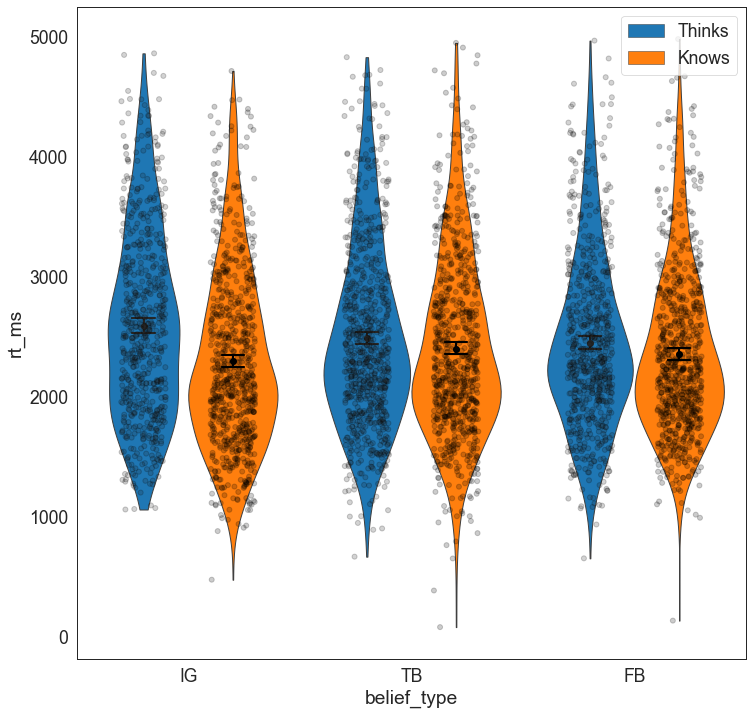

In [8]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)],
                  color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

fig.savefig('control_rt.png')

In [9]:
len(dat.prolific_id.unique())

423

# Felicity Judgements

In [31]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('knwlg_blf.db')
f_dat = pd.read_sql('SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
f_dat = f_dat.loc[:,~f_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

# 1= "Sounds very weird"
# 7 = "Sounds very normal"
f_dat['Infelicity Rating'] = 8 - f_dat.felicity_rating

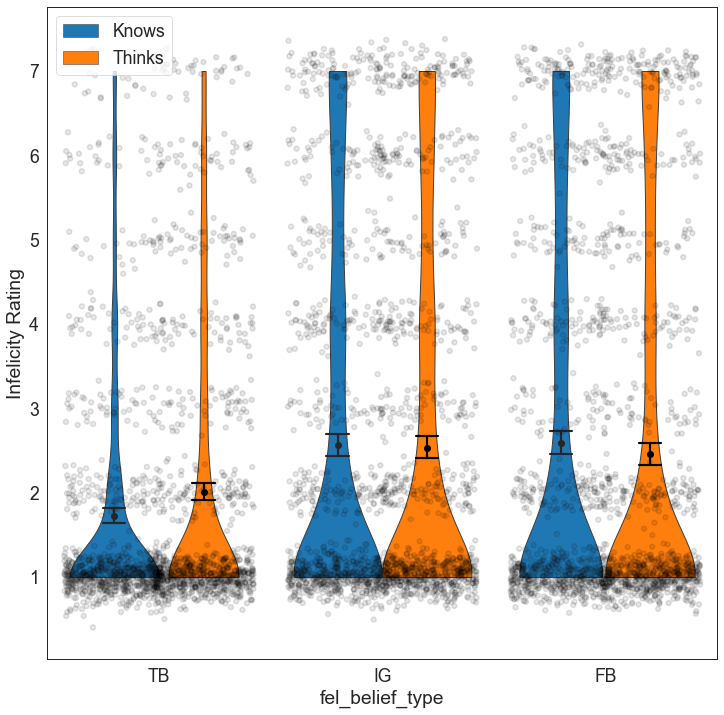

In [36]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1, order=['TB', 'IG', 'FB'])

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='fel_belief_type', y=jitter(f_dat['Infelicity Rating'], 0), hue='fel_ascription_type', data=f_dat,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['TB', 'IG', 'FB'])
g= sns.pointplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['TB', 'IG', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

fig.savefig('control_fel.png')

In [37]:
len(f_dat.prolific_id.unique())

501